In [44]:
from pathlib import Path
import pickle
import copy

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt

from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [45]:
plt.rcParams.update({"font.size": 14})

In [46]:
cwd = Path().cwd()

# Setting up the system

In [47]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1_excited=3 / 2, F_excited=1
    ),
]

polarizations = [
    [
        couplings.polarization_X,
        couplings.polarization_Y,
    ],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.states.CoupledBasisState(
            J=1,
            F1=1 / 2,
            F=1,
            mF=0,
            I1=1 / 2,
            I2=1 / 2,
            P=-1,
            Ω=0,
            electronic_state=states.ElectronicState.X,
        )
    ],
    excited_mains=[
        1
        * states.states.CoupledBasisState(
            J=2,
            F1=3 / 2,
            F=1,
            mF=1,
            I1=1 / 2,
            I2=1 / 2,
            P=+1,
            Ω=1,
            electronic_state=states.ElectronicState.B,
        ),
    ],
)


In [48]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    δ0=0.0,
    # polarization modulation
    Pl0="resonant_polarization_modulation(t, γ, ωpol)",
    PX0="Pl0",
    PY0="-sqrt(Pl0*Pl0-1j)",
    # Pl0="square_wave(t, ωpol, 0.0)",
    # PX0="Pl0",
    # PY0="1-Pl0",
    ωpol=2 * np.pi * 1e6,
    γ=np.pi / 2,
)


In [49]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=states.QuantumSelector(J=3, electronic=states.ElectronicState.X),
    decay_channels=None,
)


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
c:\Users\ogras\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\Lib\site-packages\centrex_tlf\couplings\collapse.py:64: UserWarning: Branching ratio sum > 1, difference = 2.22e-16
  warnings.warn(
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 6.52 s
Wall time: 6.55 s


In [50]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_original, transition_selectors, odepars
)


In [51]:
print(obe_system.preamble)

function Lindblad_rhs!(du, ρ, p, t)
    	@inbounds begin
    		Ω0 = p[1]
		δ0 = p[2]
		ωpol = p[3]
		γ = p[4]
		Pl0 = resonant_polarization_modulation(t, γ, ωpol)
		PX0 = Pl0
		PY0 = -sqrt(Pl0 .^ 2 - 1im)



In [52]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X), obe_system.QN
)


# Single parameter only

In [53]:
for coupling in obe_system.couplings:
    print(
        round(
            utils.rabi.intensity_to_rabi(
                50e-3 / (25.4e-3 * 25.4e-3),
                coupling.main_coupling.real,
                D=2.6675506e-30,
            )
            / hamiltonian.Γ,
            3,
        )
    )


-0.14


In [54]:
odepars.Ω0 = 0.14 * hamiltonian.Γ
odepars.δ0 = 0.0 * hamiltonian.Γ
odepars.ωpol = 0.3 * hamiltonian.Γ
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 100e-6))
config = lindblad_julia.OBEProblemConfig(
    method="Tsit5()", saveat=1e-6, abstol=1e-13, reltol=1e-10
)

results = lindblad_julia.do_simulation_single(problem, config=config)


In [55]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

qn_select_J1 = states.QuantumSelector(J=1, electronic=states.ElectronicState.X)
indices_J1 = qn_select_J1.get_indices(obe_system.QN)

qn_select_J3 = states.QuantumSelector(J=3, electronic=states.ElectronicState.X)
indices_J3 = qn_select_J3.get_indices(obe_system.QN)


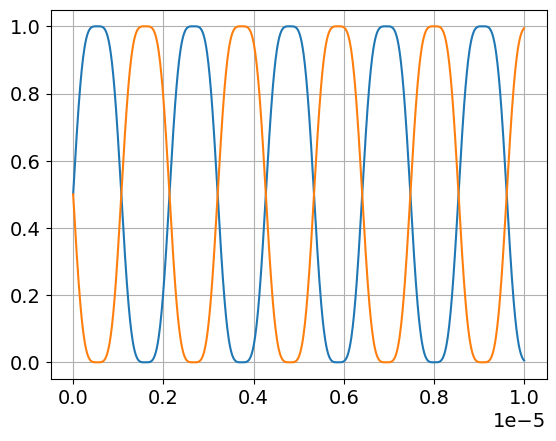

In [56]:
_t = np.linspace(0, 10e-6, 1001)
y0 = odepars.get_parameter_evolution(_t, "PX0")
y1 = odepars.get_parameter_evolution(_t, "PY0")

# intensity plot, |rabi|^2
fig, ax = plt.subplots()
ax.plot(_t, np.abs(y0) ** 2)
ax.plot(_t, np.abs(y1) ** 2)

ax.grid()


2.33 photons


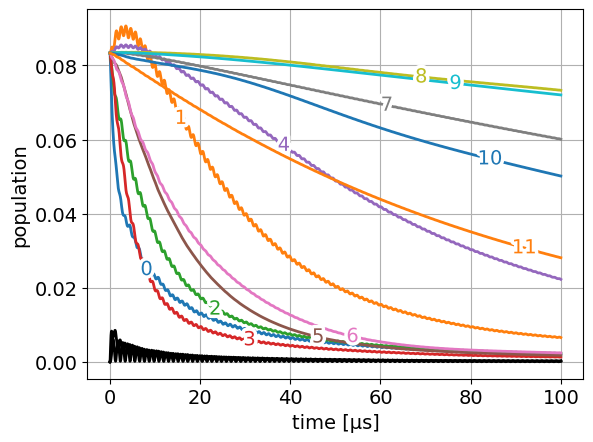

In [57]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_J1].T, lw=2, label=indices_J1)

labelLines(ax.get_lines(), align=False, fontsize=14)

ax.plot(results.t * 1e6, results.y[indices_excited].T, lw=2, color="k")

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

nphotons = np.trapezoid(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")
